<a href="https://colab.research.google.com/github/allenphos/Study-projects/blob/main/Polynomial_Feature_Engineering_for_Enhanced_Churn_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Customer Churn Prediction – Optimized Version (Kaggle Competition)

This notebook presents a complete pipeline for solving the binary classification problem of predicting customer churn using logistic regression. The solution is developed for the Kaggle competition ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2).

The notebook covers all stages of the machine learning workflow, including:

- Data Preprocessing: Handling missing values, encoding categorical features, and scaling numerical features.
- Feature Engineering: Experimenting with polynomial features to improve model performance by capturing non-linear relationships.
- Model Training: Training a logistic regression model using the processed data.
- Model Evaluation: Evaluating the model using metrics such as ROC-AUC and confusion matrix.

Additionally, experiments with polynomial features (degree 2 and 5) are conducted to analyze their impact on model performance, aiming to improve generalization and model accuracy.

## Imports

In [1]:
!pip install opendatasets --upgrade --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from sklearn.model_selection import GridSearchCV
import opendatasets as od

## Data Preprocessing

In [2]:
# Download the dataset
od.download("https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2")
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/train.csv', index_col=0)

# Create training, validation and test sets
train_val_df, test_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['Exited'], random_state=42)

# Create inputs and targets
input_cols = list(train_df.columns)[3:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that includes preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anastasiaalyoshkina
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 72.1MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./bank-customer-churn-prediction-dlu-course-c-2


## Model Training and Evaluation

Area under ROC score on Training dataset: 0.8839%
[[0.95843214 0.04156786]
 [0.46149645 0.53850355]]


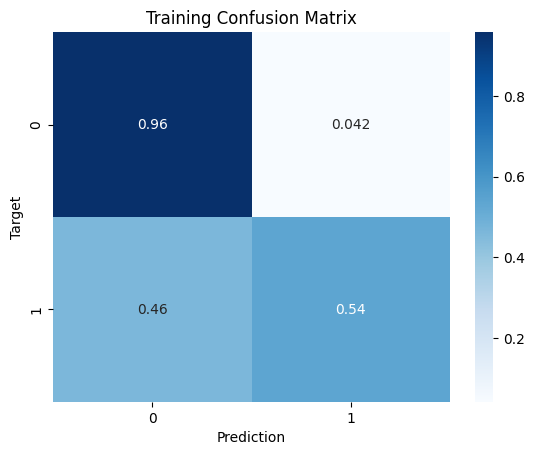

Area under ROC score on Validation dataset: 0.8752%
[[0.95604856 0.04395144]
 [0.4599018  0.5400982 ]]


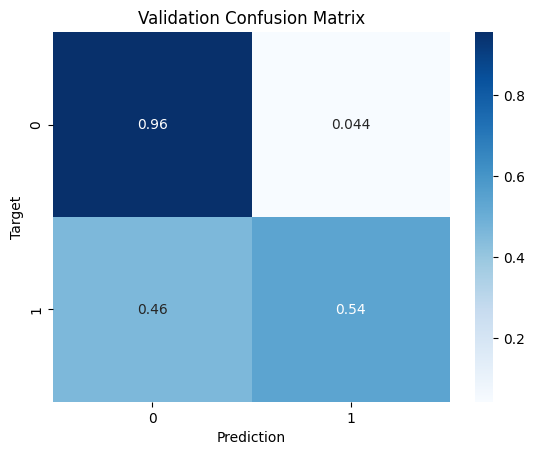

['log_reg_pipeline.joblib']

In [3]:
# GridSearchCV
param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model_pipeline, param_grid, scoring='roc_auc', cv=5)

# Train the model
grid_search.fit(train_inputs, train_targets)

# Get the best model
best_model = grid_search.best_estimator_


# Helper function to predict, compute accuracy & plot confusion matrix
def predict_and_plot(model, inputs, targets=None, name=''):
    preds_proba = model.predict_proba(inputs)[:, 1]
    preds = model.predict(inputs)

    # Visualization
    if targets is not None:
        fpr, tpr, thresholds = roc_curve(targets, preds_proba, pos_label=1)
        roc_auc = auc(fpr, tpr)
        print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}%")

        confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
        print(confusion_matrix_)
        plt.figure()
        sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
        plt.xlabel('Prediction')
        plt.ylabel('Target')
        plt.title(f'{name} Confusion Matrix')
        plt.show()

    return preds

# Evaluate on validation and test set
train_preds = predict_and_plot(best_model, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(best_model, val_inputs, val_targets, 'Validation')

# Save the trained model
joblib.dump(best_model, 'log_reg_pipeline.joblib')

## Experimentation with Polynomial Features

- Generated polynomial features (degree 2 and 5) to capture nonlinear relationships.
- Compared model performance across different polynomial degrees.
- Assessed overfitting and generalization capabilities.

Area under ROC score on Training dataset: 0.9306%
[[0.96205886 0.03794114]
 [0.33096668 0.66903332]]


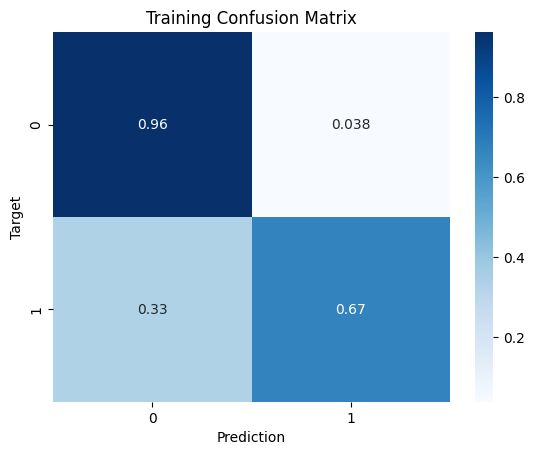

Area under ROC score on Validation dataset: 0.9237%
[[0.95646714 0.04353286]
 [0.34697218 0.65302782]]


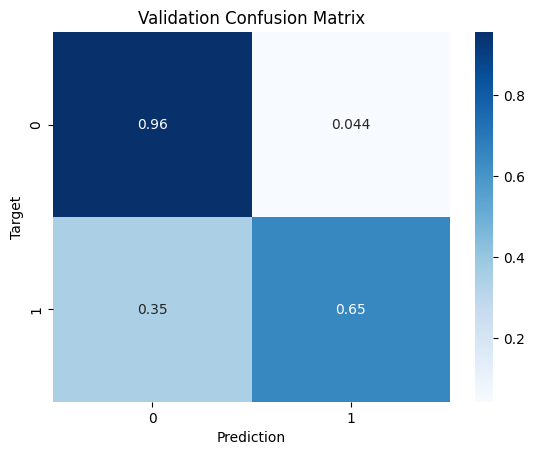

In [4]:
from sklearn.preprocessing import PolynomialFeatures

# New transformer for numerical columns with polynomial features
numeric_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())  # Normalization after feature generation
])

# Updated preprocessor
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# New pipeline
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Model training
model_pipeline_poly.fit(train_inputs, train_targets)

# Evaluate on validation and test set
train_preds = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, 'Validation')



It seems that the model generalizes well. The accuracy of the model has improved.

Area under ROC score on Training dataset: 0.9426%
[[0.96136142 0.03863858]
 [0.30857455 0.69142545]]


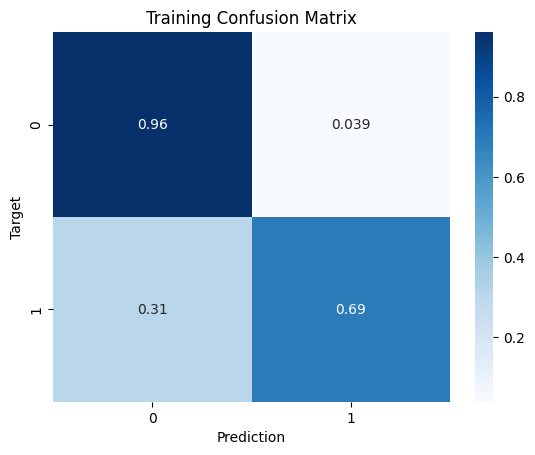

Area under ROC score on Validation dataset: 0.9268%
[[0.95814148 0.04185852]
 [0.30932897 0.69067103]]


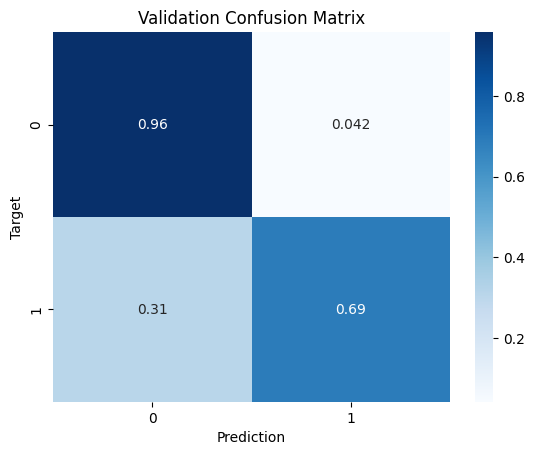

In [7]:
# New transformer for numerical columns with polynomial features
numeric_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', StandardScaler())  # Normalization after feature generation
])

# Updated preprocessor
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# New pipeline
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Model training
model_pipeline_poly.fit(train_inputs, train_targets)

# Evaluate on validation and test set
train_preds = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, 'Validation')

The accuracy of the model has slightly improved, ROC score: 0.93%. And so far, this is the best result.

## Results and Observations

Polynomial features improved model ROC-AUC score. The model generalizes well without significant overfitting.